#DoctoPlant - Classification using Tensorflow 2.x

## 1. Environment preparation

1. Check if Drive is connected
2. Unzip dataset

It's faster to copy the Dataset from our own Drive to Collab environment. And form there, unzip the Dataset and start working on it.

It takes overall less than 5 minutes to copy and unzip the whole Dataset, so it worth it to follow this process.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip train & valid DataSet
!unzip -u "/content/drive/MyDrive/20 - Data/DataSet/dataset.zip" -d "/content/sample_data"
# Unzip test DataSet
!unzip -u "/content/drive/MyDrive/20 - Data/DataSet_Test.zip" -d "/content/sample_data/DataSet_Test"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sample_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/sample_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: /content/sample_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/29050f21-a393-473e-9f9c-7fd99feef9a7___RS_HL 4533_180deg.JPG  
  inflating: /content/sample_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/29050f21-a393-473e-9f9c-7fd99feef9a7___RS_HL 4533_90deg.JPG  
  inflating: /content/sample_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___h

### Use GPU

For the purpose of Image Classification, we will use Google GPU to allow us to use Google resources. This will help us to considerably improve the capacity of the laptop to execute ML programs.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f"Tensorflow version: {tf.__version__}")
print('Found GPU at: {}'.format(device_name))

Tensorflow version: 2.4.1
Found GPU at: /device:GPU:0


## 2. Initialisation code 

In [ ]:
# Import required packages
import os 
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Get Path to Train and Valid folders
train_path = '/content/sample_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_path = '/content/sample_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_path='/content/sample_data/DataSet_Test'

#os.remove('/content/sample_data/clem_test_img_pour_selva/.DS_Store')

# Get list of all subfolders for each Subset
train_dir = os.listdir(train_path)
valid_dir = os.listdir(valid_path)
test_dir = os.listdir(test_path)
# Check length of subfolders
print('number of classes in the train DataSet',len(train_dir))
print('number of classes in the valid DataSet',len(valid_dir))
print('number of classes in the test DataSet',len(test_dir))

number of classes in the train DataSet 38
number of classes in the valid DataSet 38
number of classes in the test DataSet 38


We will create DataFrame to stor required information for our program.
DataFrames are the same used during **Data Vizualisation** report.

Train and Validation Dataframe composed of:
- List of Plants name (Plant)
- List of Plants Categories (Category)
- List of images path (Path) > Features
- List of Plants name + Plants Categories (Plant___Category) > Labels
- If Plant is diseased or not (Disease)

In [ ]:
# Create Dataframe

def create_info_df(path):
  """
  input: `path` - folder path
  From folder path, create a Dataframe with columns: 
    Plant | Category | Path | Plant___Category | Disease
  return DataFrame
  """

  list_plants = []
  list_dir = os.listdir(path) # Get list direcotry
  # Go through each folder to create url and get required information
  for plant in list_dir:
      url = path +'/'+plant
      for img in os.listdir(url):
          list_plants.append([*plant.split('___',1), url+'/'+img, plant])
  
  # Create DataFrame
  df = pd.DataFrame(list_plants, columns=['Plant', 'Category', 'Path','Plant___Category'])
  # Add `Disease` column - if folder name is not Healthy then plant is diseased
  df['Disease'] = df.Category.apply(lambda x: 0 if x=='healthy' else 1)

  return df

# Get Validation and Training DF
train_info = create_info_df(train_path)
valid_info = create_info_df(valid_path)
test_info = create_info_df(test_path)

# Shuffle datasets
train_info = train_info.sample(frac = 1)
valid_info = valid_info.sample(frac = 1)


#Unique label list:
unique_plant_cat = np.unique(train_info['Plant___Category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))
list_class=unique_plant_cat.tolist()

# Add column integer label
train_info['Label_int'] =train_info['Plant___Category'].apply(lambda x: list_class.index(x))
valid_info['Label_int'] =valid_info['Plant___Category'].apply(lambda x: list_class.index(x))
test_info['Label_int'] =test_info['Plant___Category'].apply(lambda x: list_class.index(x))
print('number of images of train dataset:',len(train_info))
print('number of images of valid dataset:',len(valid_info))
print('number of images of test dataset:',len(test_info))

Number of Categories to predict:  38
number of images of train dataset: 70295
number of images of valid dataset: 17572
number of images of test dataset: 1473


In [ ]:
valid_info.head()

,Plant,Category,Path,Plant___Category,Disease,Label_int
15142,Peach,healthy,/content/sample_data/New Plant Diseases Datase...,Peach___healthy,0,17
5299,Corn_(maize),healthy,/content/sample_data/New Plant Diseases Datase...,Corn_(maize)___healthy,0,10
16306,Grape,healthy,/content/sample_data/New Plant Diseases Datase...,Grape___healthy,0,14
1693,"Pepper,_bell",healthy,/content/sample_data/New Plant Diseases Datase...,"Pepper,_bell___healthy",0,19
7485,Grape,Esca_(Black_Measles),/content/sample_data/New Plant Diseases Datase...,Grape___Esca_(Black_Measles),1,12


In [ ]:
# Parameters
IMG_SIZE = 128
IMG_SHAPE = 128,128,3
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
OUTPUT_SHAPE = 38
NUM_EPOCHS = 25
BUFFER_SIZE = 1000

# MODELS

## 1. Create own CNN

In [ ]:
#@tf.function
def load_image(path,label_int,img_shape,list_classes):
  #Load and decode image
  img=tf.io.read_file(path)
  img=tf.image.decode_jpeg(img,channels=3)

  #Resize image ans scale it from [0-255] to [0-1]
  img=tf.image.resize(img,img_shape[:2])/255

  #Transform label integer to one hot vector
  label_one_hot=tf.one_hot(label_int,depth=len(list_classes))

  return img,label_one_hot

#Create DataSet with Path and Label
dataset_train=tf.data.Dataset.from_tensor_slices((train_info['Path'],train_info['Label_int']))
dataset_valid=tf.data.Dataset.from_tensor_slices((valid_info['Path'],valid_info['Label_int']))
dataset_test=tf.data.Dataset.from_tensor_slices((test_info['Path'],test_info['Label_int']))

#Apply function load_image to the DataSet
dataset_train=dataset_train.map(lambda x,y : load_image(x,y,IMG_SHAPE,list_class),num_parallel_calls=-1).shuffle(buffer_size=BUFFER_SIZE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset_valid=dataset_valid.map(lambda x,y : load_image(x,y,IMG_SHAPE,list_class)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset_test=dataset_test.map(lambda x,y : load_image(x,y,IMG_SHAPE,list_class)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation

INPUT_SHAPE = IMG_SHAPE


def get_model():
  # L2 regularization to limit over-fitting
  regularizer = tf.keras.regularizers.l2(5e-3)

  model_v2 = Sequential([
    # First CNN                     
    Conv2D(128,(3,3),activation='relu', input_shape=INPUT_SHAPE,kernel_regularizer=regularizer),
    BatchNormalization(),
    MaxPooling2D(),

    # Second CNN
    Conv2D(256,(3,3),activation='relu',kernel_regularizer=regularizer),
    BatchNormalization(),
    MaxPooling2D(),

    # Third CNN
    Conv2D(512,(3,3),activation='relu',kernel_regularizer=regularizer),
    BatchNormalization(),
    MaxPooling2D(),

    # GlobalAveragePooling2D of the last CNN output for Dense layers
    GlobalAveragePooling2D(),
    Dense(512, activation='relu',kernel_regularizer=regularizer),
    Dropout(0.2),
    Dense(256, activation='relu',kernel_regularizer=regularizer),
    Dropout(0.2),
    # Return 38 probabilities (= number of plants we want to predict)
    Dense(OUTPUT_SHAPE, activation= 'softmax')
  ])

  return model_v2

#with strategy.scope():
model = get_model()
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
# Show Summary 
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 126, 128)     512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 61, 61, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 512)      

In [ ]:
# Callbacks
# Early stopping Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)

# Reduce learning rate after 5 Epoch
def scheduler(epoch, lr):
  if epoch %5== 0:
    return lr * 0.2
  else:
    return lr

lr_callback =tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Train Model
history = model.fit(dataset_train,
                  epochs=NUM_EPOCHS,
                  validation_data=dataset_valid,
                  callbacks=[early_stopping, lr_callback])

# Get Validation Loss and Accuracy
val_loss, val_acc = model.evaluate(dataset_valid)
val_acc = round(val_acc, 3)

print('Accuracy for validation DataSet:',val_acc)

# Save model
model.save('/content/drive/MyDrive/00 - Rendu Final/031 - Iteration 1 (Dataset one leaf)/Moel_CNN_iter_1.h5')


Epoch 1/25
2197/2197 [==============================] - 439s 196ms/step - loss: 5.7430 - accuracy: 0.5972 - val_loss: 1.7056 - val_accuracy: 0.8459
Epoch 2/25
2197/2197 [==============================] - 422s 192ms/step - loss: 1.2591 - accuracy: 0.9013 - val_loss: 1.8777 - val_accuracy: 0.6221
Epoch 3/25
2197/2197 [==============================] - 422s 192ms/step - loss: 0.7340 - accuracy: 0.9281 - val_loss: 0.8622 - val_accuracy: 0.8715
Epoch 4/25
2197/2197 [==============================] - 421s 191ms/step - loss: 0.5988 - accuracy: 0.9387 - val_loss: 0.7949 - val_accuracy: 0.8637
Epoch 5/25
2197/2197 [==============================] - 420s 191ms/step - loss: 0.5316 - accuracy: 0.9471 - val_loss: 0.7240 - val_accuracy: 0.8747
Epoch 6/25
2197/2197 [==============================] - 420s 191ms/step - loss: 0.3987 - accuracy: 0.9761 - val_loss: 0.3259 - val_accuracy: 0.9820
Epoch 7/25
2197/2197 [==============================] - 421s 191ms/step - loss: 0.3277 - accuracy: 0.9795 - val_

NameError: ignored

## 2. Evaluation of model

### 1. Plot Accuracy & Loss

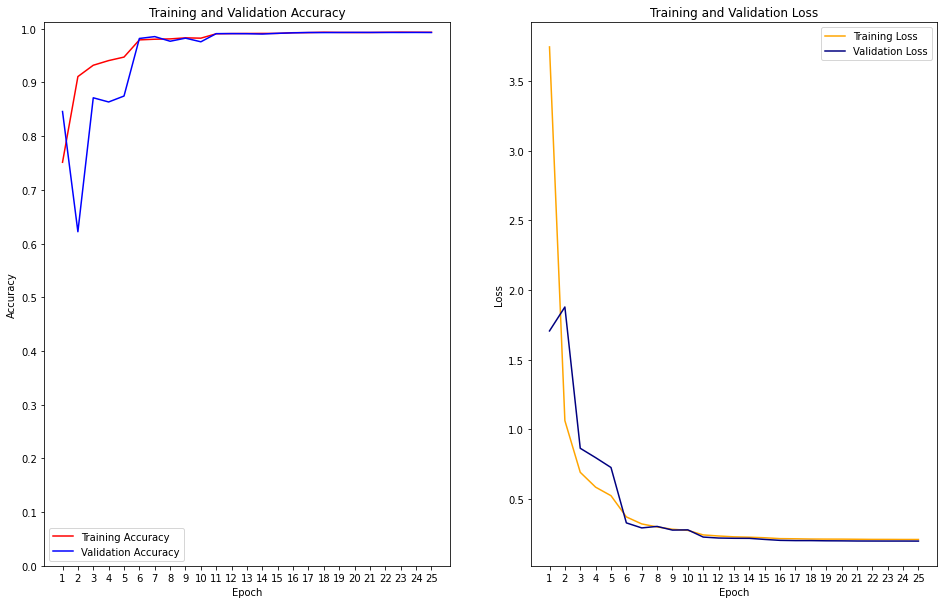

In [ ]:
# Plot Accuracy & Loss

def plot_acc_and_loss(history):
  """
  From Model History, plot two Graphs: 
   - Accuracy Train + Validation
   - Loss Train + Validation

  Input: model history
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss)+1)
  
  plt.figure(figsize=(16,10))
  
  plt.subplot(121)
  plt.plot(epochs, acc, color='red', label='Training Accuracy')
  plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.yticks(np.arange(0,1.1,0.1))
  plt.legend()
  
  plt.subplot(122)
  plt.plot(epochs, loss, color='orange', label='Training Loss')
  plt.plot(epochs, val_loss, color='navy', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.legend()

plot_acc_and_loss(history)

### 2. Confusion Matrix

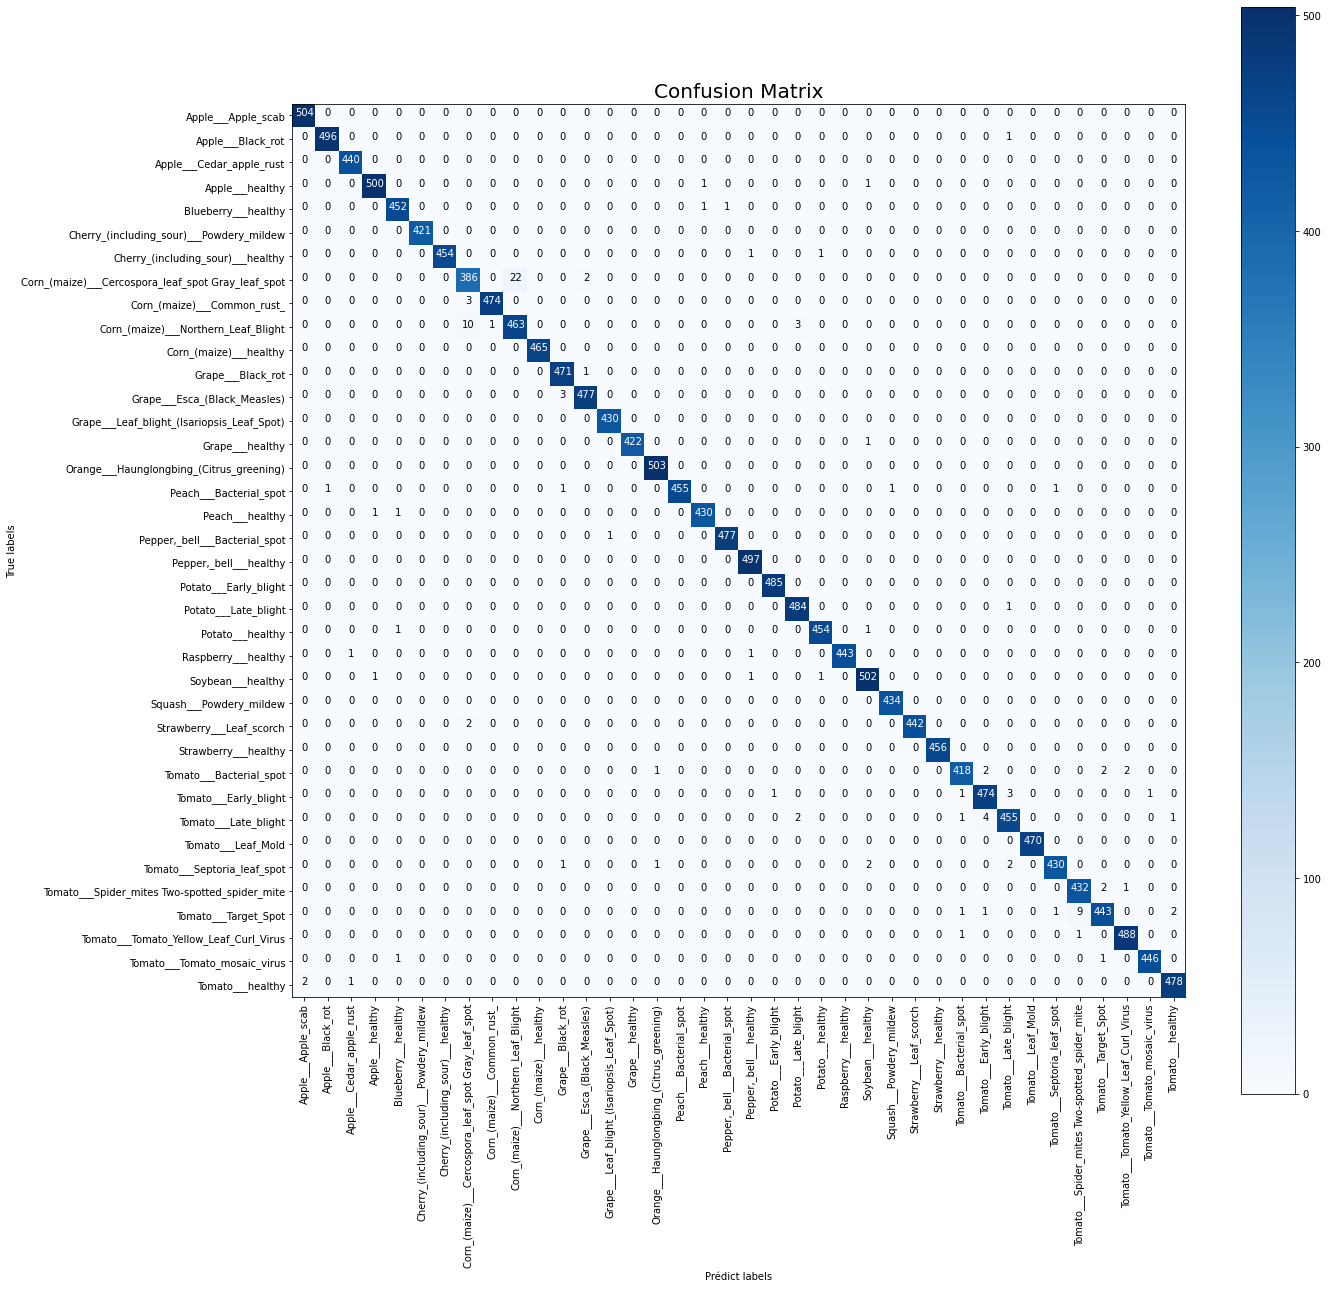

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image*255)
        lbl.append(np.argmax(label))

    return img,lbl


# Get predictions
predictions_valid = model.predict(dataset_valid)
predictions_valid_int=np.argmax(predictions_valid,axis=1)
# Get Validation datset images and true labels
imgs_valid, labels_valid = unbatchify(dataset_valid)


# Confusion matrix
from sklearn import metrics
import itertools

def Confusion_matrix(label_valid, predictions_class):
  cnf_matrix = metrics.confusion_matrix(label_valid, predictions_class)
  classes = range(0,10)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Confusion Matrix",fontsize=20)
  plt.colorbar()
  tick_marks = np.arange(len(list_class))

  plt.xticks(tick_marks, list_class, rotation='vertical')
  plt.yticks(tick_marks, list_class)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment="center",
              color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Prédict labels')
  plt.show()

Confusion_matrix(labels_valid, predictions_valid_int)

### 3. Plot Predictions

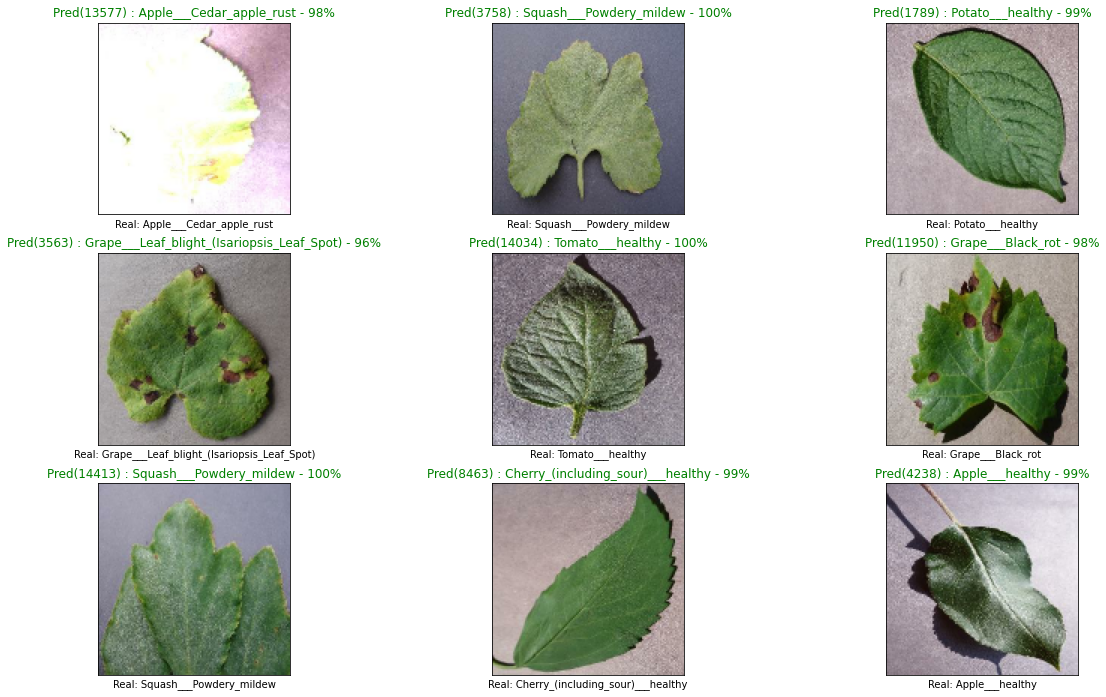

In [ ]:
# Show images and prediction rate
def show_img_and_prediction(imgs, labels,predictions, nb_img=9):

    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red'

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])

        if unique_plant_cat[np.argmax(predictions[i])] == unique_plant_cat[labels[i]]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, unique_plant_cat[np.argmax(predictions[i])], np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(unique_plant_cat[labels[i]]));

show_img_and_prediction(imgs_valid, labels_valid,predictions_valid)

## Evaluate model with Test dataset

### 1.Accuracy for test dataset

In [ ]:
# Get Validation Loss and Accuracy
val_loss_test, val_acc_test = model.evaluate(dataset_test)
val_acc_test = round(val_acc_test, 3)
print('Accuracy for test DataSet:',val_acc_test)

47/47 [==============================] - 3s 67ms/step - loss: 7.7955 - accuracy: 0.1324
Accuracy for test DataSet: 0.132


### 2. Confusion Matrix

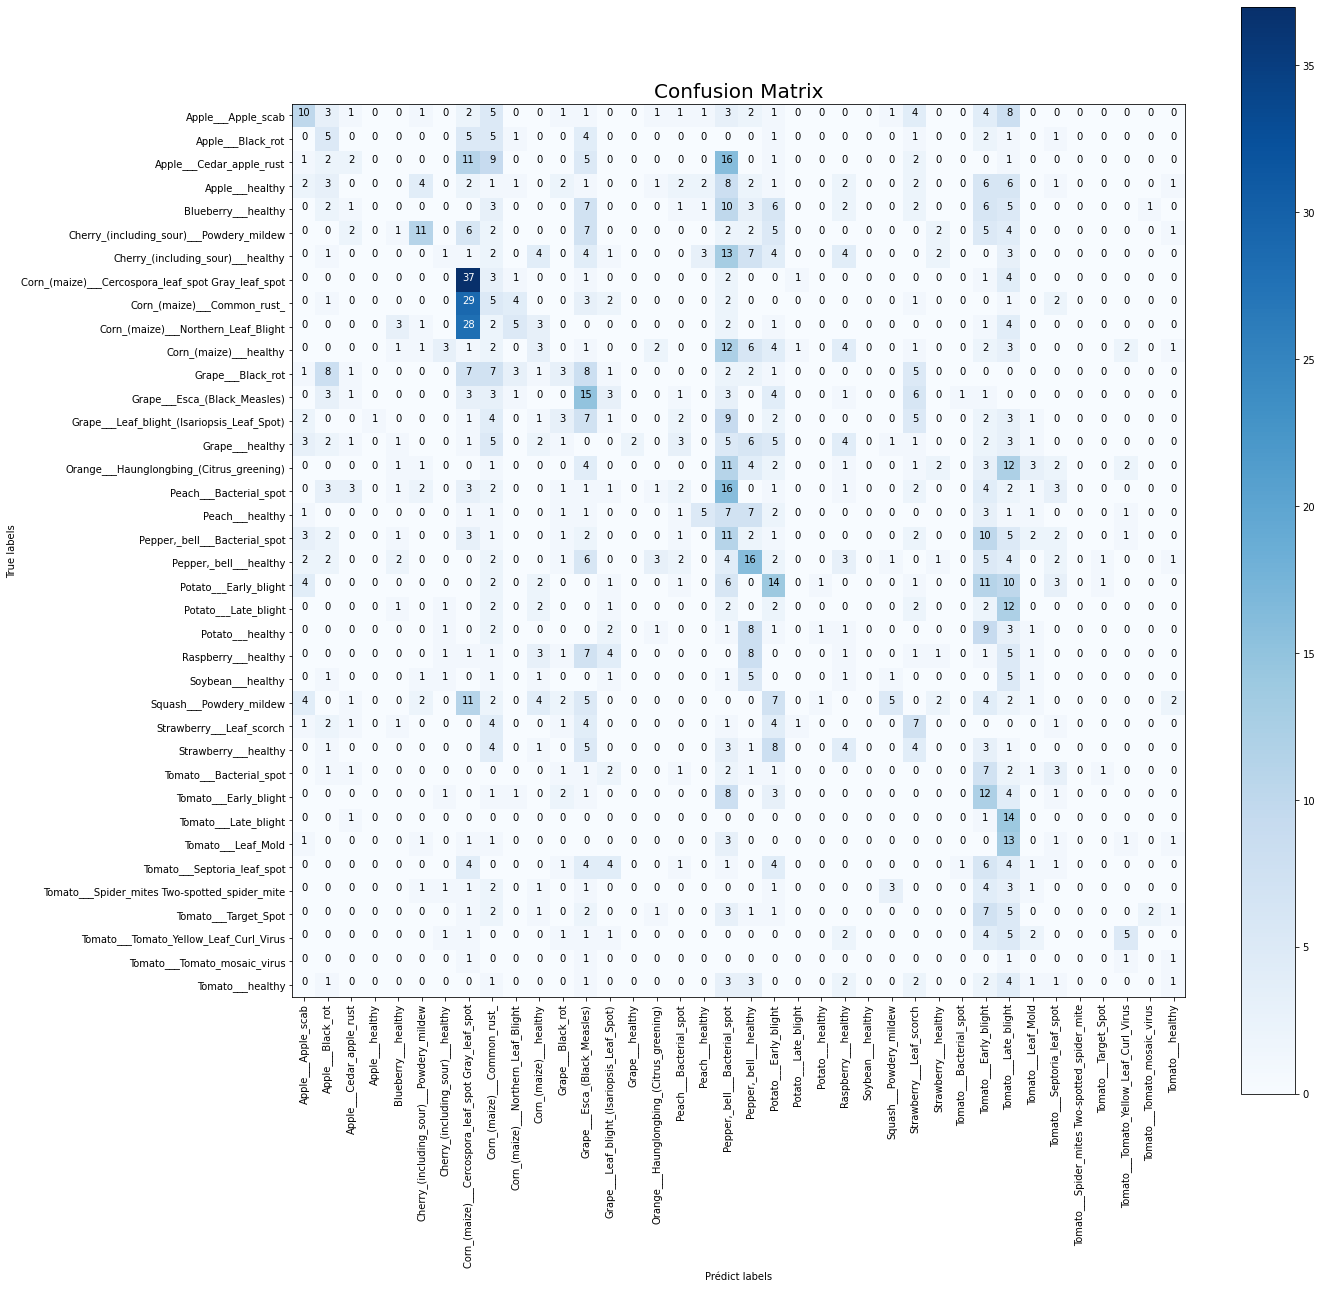

In [ ]:

# Get predictions
predictions_test = model.predict(dataset_test)
predictions_test_int=np.argmax(predictions_test,axis=1)
# Get Validation datset images and true labels
imgs_test, labels_test = unbatchify(dataset_test)

Confusion_matrix(labels_test, predictions_test_int)

### 3. Plot Predictions

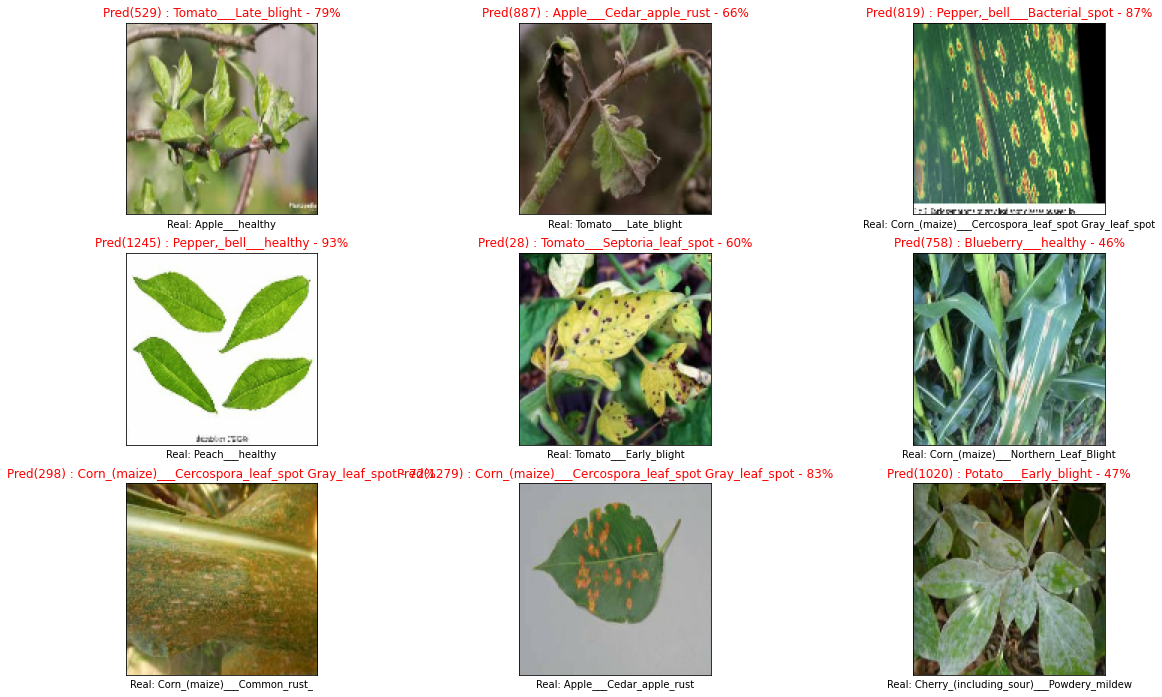

In [ ]:
show_img_and_prediction(imgs_test, labels_test,predictions_test)